In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import RFECV, RFE
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import ComplementNB

pd.set_option("display.max_columns", None)

In [6]:
bank_logit = pd.read_csv("../data/bank_selected.csv")
bank_raw = pd.read_csv("../data/bank_imputed_imp.csv")
month = pd.read_csv("../data/Casestudy Data.csv")["month"]
month = pd.get_dummies(month)

In [30]:
bank_logit.head()

bank_X = bank_logit.drop(columns = ["y"])
bank_y = bank_logit["y"]
bank_poutcome = pd.get_dummies(pd.read_csv("../data/Casestudy data.csv")["poutcome"])
bank_raw_X = bank_raw.drop(columns = ["y", "poutcome"])
bank_raw_y = bank_raw["y"]

In [8]:

logit = LogisticRegression(penalty = "none", max_iter = 500, class_weight = "balanced")
logit_fit = logit.fit(bank_X, bank_y)
print(f"Accuracy: {logit_fit.score(bank_X, bank_y)}")
print(f'Recall: {recall_score(bank_y, logit_fit.predict(bank_X), average = "binary")}')
print(f'Mean accuracy via CV: {np.mean(cross_val_score(logit, bank_X, bank_y))}')
print(f'Mean recall via CV: {np.mean(cross_validate(logit, bank_X, bank_y, scoring = "recall_macro")["test_score"])}')
print(len(logit_fit.coef_[0]))

Accuracy: 0.6562348256773818
Recall: 0.6491379310344828
Mean accuracy via CV: 0.5531839602586675
Mean recall via CV: 0.4972273221048053
27


In [9]:
selector = RFECV(LogisticRegression(max_iter = 1000, class_weight = "balanced"), scoring = "f1_macro", n_jobs = -1)
selector = selector.fit(bank_X, bank_y)
logit_feature = bank_X.columns[selector.support_]
logit_feature

Index(['previous', 'job_blue-collar', 'job_entrepreneur', 'job_retired',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_single', 'education_basic.4y', 'education_basic.9y',
       'education_high.school', 'contact_cellular'],
      dtype='object')

In [10]:
logit_rfe = LogisticRegression(penalty = "none", max_iter = 500, class_weight = "balanced")
logit_rfe_fit = logit_rfe.fit(bank_X[logit_feature], bank_y)
print(f"Accuracy: {logit_rfe_fit.score(bank_X[logit_feature], bank_y)}")
print(f'Recall: {recall_score(bank_y, logit_rfe_fit.predict(bank_X[logit_feature]), average = "binary")}')
print(f'Mean accuracy via CV: {np.mean(cross_val_score(logit_rfe, bank_X[logit_feature], bank_y))}')
print(f'Mean recall via CV: {np.mean(cross_validate(logit_rfe, bank_X[logit_feature], bank_y, scoring = "recall_macro")["test_score"])}')

logit_rfe_fit.coef_

Accuracy: 0.653855491890842
Recall: 0.6344827586206897
Mean accuracy via CV: 0.5637451031520885
Mean recall via CV: 0.5757120660726883


array([[ 0.78754608, -0.32657596, -0.18223242,  0.888715  , -0.28422023,
         0.87412892, -0.17090012,  0.20972255,  0.23406688, -0.19805222,
        -0.24448415, -0.13623515,  0.85014997]])

In [11]:
# Regularization
logit_cv = LogisticRegressionCV(penalty = "l2", class_weight = "balanced", scoring = "f1_macro", n_jobs = -1)
logit_cv_fit = logit_cv.fit(bank_X[logit_feature], bank_y)

print(f"Accuracy: {logit_cv_fit.score(bank_X[logit_feature], bank_y)}")
print(f'Recall: {recall_score(bank_y, logit_cv_fit.predict(bank_X[logit_feature]), average = "binary")}')
print(f'Mean accuracy via CV: {np.mean(cross_validate(logit_cv, bank_X[logit_feature], bank_y, scoring = "accuracy")["test_score"])}')
print(f'Mean recall via CV: {np.mean(cross_validate(logit_cv, bank_X[logit_feature], bank_y, scoring = "recall_macro")["test_score"])}')

logit_cv.coef_

Accuracy: 0.5330577924973359
Recall: 0.6351293103448276
Mean accuracy via CV: 0.5712957830392609
Mean recall via CV: 0.5565410822985136


array([[ 0.75338932, -0.34417199, -0.13369637,  0.63587281, -0.26125504,
         0.52199415, -0.16155296,  0.10811484,  0.23589579, -0.110154  ,
        -0.1942437 , -0.10623948,  0.78989028]])

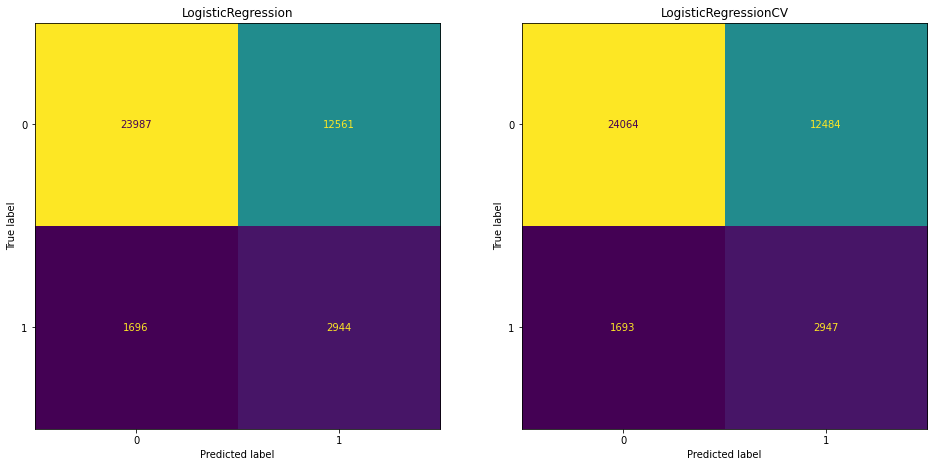

In [12]:
# Confusion matrix
models = [logit_rfe_fit, logit_cv_fit]
fig, ax = plt.subplots(1, 2, figsize = (16, 16))
for i in range(len(models)):
    pred = models[i].predict(bank_X[logit_feature])
    cm = confusion_matrix(bank_y, pred, labels = models[i].classes_)

    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = models[i].classes_)
    disp.plot(ax = ax[i], colorbar = False)
    ax[i].set_title(str(models[i]).split("(")[0])


In [31]:
# Random forest
bank_raw_X = bank_raw_X.join(bank_poutcome)

In [32]:
bank_poutcome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   failure      41188 non-null  uint8
 1   nonexistent  41188 non-null  uint8
 2   success      41188 non-null  uint8
dtypes: uint8(3)
memory usage: 120.8 KB


In [33]:
def plot_imporatance(model):
    importance = model.feature_importances_[model.feature_importances_ != 0]
    feature = bank_raw_X.columns[model.feature_importances_ != 0]

    feature_importance = np.sort(np.stack((feature, importance), axis = 1), axis = 0)[::-1]
    np.sum(feature_importance[:, 1])

    feature = [i[0] for i in feature_importance]
    importance = [i[1] for i in feature_importance]

    plt.figure(figsize = (8, 8))
    plt.barh(feature, importance, height = 0.75)
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

In [34]:
rf = RandomForestClassifier(class_weight = "balanced", n_jobs = -1)
rf_prun = RandomForestClassifier(class_weight = "balanced", min_weight_fraction_leaf = 0.4, max_samples = 0.2)

In [35]:
rf_fit = rf.fit(bank_raw_X, bank_raw_y)
rf_fit.score(bank_raw_X, bank_raw_y)

0.9945372438574342

In [36]:
np.mean(cross_validate(rf, bank_raw_X, bank_raw_y, n_jobs = -1, scoring = "accuracy", cv = 10)["test_score"])

0.5582083277473313

In [17]:
np.mean(cross_validate(rf, bank_raw_X, bank_raw_y, n_jobs = -1, scoring = "recall_macro", cv = 10)["test_score"])

0.3704414792514172

In [18]:
recall_score(bank_raw_y, rf_fit.predict(bank_raw_X))

0.997198275862069

In [37]:
GridSearchCV(estimator = rf_prun, param_grid = {"min_weight_fraction_leaf": np.arange(0, 0.5, 0.05)}, cv = 10, verbose = True, n_jobs = -1, scoring = "f1_macro").fit(bank_raw_X, bank_raw_y).best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


{'min_weight_fraction_leaf': 0.4}

In [40]:
rf_prun_fit = rf_prun.fit(bank_raw_X, bank_raw_y)
rf_prun_fit.score(bank_raw_X, bank_raw_y)

0.7199184228416043

In [41]:
np.mean(cross_validate(rf_prun, bank_raw_X, bank_raw_y, n_jobs = -1, scoring = "accuracy", cv = 10)["test_score"])

0.6349168572981956

In [42]:
np.mean(cross_validate(rf_prun, bank_raw_X, bank_raw_y, n_jobs = -1, scoring = "recall_macro", cv = 10)["test_score"])

0.6785770260389642

In [43]:
recall_score(bank_raw_y, rf_prun_fit.predict(bank_raw_X))

0.7114224137931034

In [46]:
bank_raw_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  float64
 1   default                        41188 non-null  float64
 2   housing                        41188 non-null  float64
 3   loan                           41188 non-null  float64
 4   campaign                       41188 non-null  float64
 5   pdays                          41188 non-null  float64
 6   previous                       41188 non-null  float64
 7   emp.var.rate                   41188 non-null  float64
 8   cons.price.idx                 41188 non-null  float64
 9   cons.conf.idx                  41188 non-null  float64
 10  euribor3m                      41188 non-null  float64
 11  nr.employed                    41188 non-null  float64
 12  job_admin.                     41188 non-null 

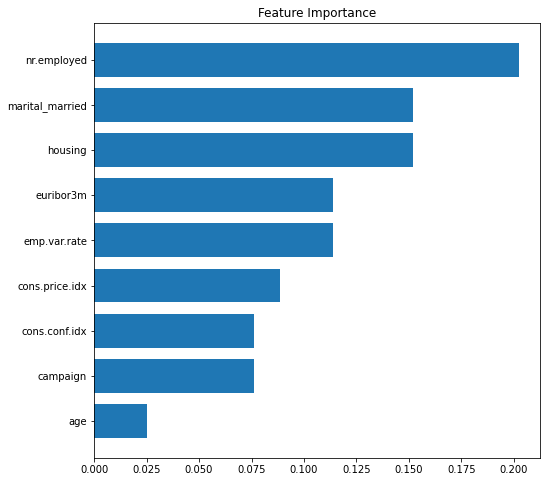

In [44]:
plot_imporatance(rf_prun_fit)

In [53]:
#
bank_X_nb = bank_X
bank_X_nb.loc[bank_X_nb["default"] < 0, "default"] = 0
bank_X_nb.loc[bank_X_nb["housing"] < 0, "housing"] = 0
bank_X_nb["cons.conf.idx"] = bank_X_nb["cons.conf.idx"] * -1

In [54]:
np.sum(bank_X_nb < 0)

age                              0
default                          0
housing                          0
loan                             0
campaign                         0
previous                         0
cons.conf.idx                    0
nr.employed                      0
job_admin.                       0
job_blue-collar                  0
job_entrepreneur                 0
job_housemaid                    0
job_management                   0
job_retired                      0
job_self-employed                0
job_services                     0
job_student                      0
job_technician                   0
job_unemployed                   0
marital_single                   0
education_basic.4y               0
education_basic.6y               0
education_basic.9y               0
education_high.school            0
education_professional.course    0
education_university.degree      0
contact_cellular                 0
dtype: int64

In [55]:
nb = ComplementNB()
nb_fit = nb.fit(bank_X_nb, bank_y)

nb_fit.score(bank_X_nb, bank_y)

0.6925075264640187

In [84]:
recall_score(bank_y, nb_fit.predict(bank_X))

0.561853448275862

In [82]:
np.mean(cross_validate(nb, bank_X, bank_y, scoring = "accuracy")["test_score"])

0.6186179769084734

In [83]:
np.mean(cross_validate(nb, bank_X, bank_y, scoring = "recall_macro")["test_score"])

0.5613804572871668

In [77]:
# SVM
svc = make_pipeline(StandardScaler(), SVC(gamma = 'auto', class_weight = "balanced", kernel = "linear"))
svc_fit = svc.fit(bank_X, bank_y)
# SVM is very resource consuming, and it is not easy to interpret despite possible high accuracy

SyntaxError: invalid character '（' (U+FF08) (680010481.py, line 5)

In [78]:
svc_fit.score(bank_X, bank_y)

0.7199669806739827

In [79]:
recall_score(bank_y, svc_fit.predict(bank_X))

0.7112068965517241